In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = 0

from importlib import import_module
from sklearn.model_selection import KFold
from monai.transforms import (
    Compose,
    ScaleIntensityd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized,
)
import numpy as np
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import jaccard_score

# special imports
from datasets_utils.datasets import ABUS_dataset
sys.path.append(str(repo_path / 'SAMed')) if str(repo_path / 'SAMed') not in sys.path else None
from SAMed.segment_anything import sam_model_registry

# Inference of SAMed

## Setup

In [2]:
# HP
run_name = 'vanilla_1class'
fold_num = 0

# run path
weights_path = repo_path / f'experiments/SAMed_ABUS/results/{run_name}/fold{fold_num}/weights'
dirs = os.listdir(weights_path)

Model

In [3]:
# get SAM model
checkpoint_dir = repo_path / 'checkpoints'
sam, _ = sam_model_registry['vit_b'](image_size=256,
                                    num_classes=8,
                                    checkpoint=str(checkpoint_dir / 'sam_vit_b_01ec64.pth'),
                                    pixel_mean=[0, 0, 0],
                                    pixel_std=[1, 1, 1])
# load lora model
pkg = import_module('sam_lora_image_encoder')
model = pkg.LoRA_Sam(sam, 4)
# load weighs
load_path = repo_path / 'experiments/SAMed_ABUS/results/pretrained_weights/fold0/weights/epoch_25.pth'
model.load_lora_parameters(str(load_path))
model.eval()
model.to(device);

Data

In [4]:
# create fold
kf = KFold(n_splits=5,shuffle=True,random_state=0)
for fold_n, (_, val_ids) in enumerate(kf.split(range(100))):
    break
print(f'The number of patients in the validation set is {len(val_ids)}')
print(f'The patient ids in the validation set are {val_ids}')
# transform
val_transform = Compose(
        [
            EnsureChannelFirstd(keys=['label'], channel_dim='no_channel'),

            ScaleIntensityd(keys=["image"]),

            Resized(keys=["image", "label"], spatial_size=(256, 256),mode=['area','nearest']),
            EnsureTyped(keys=["image"])
        ])

The number of patients in the validation set is 20
The patient ids in the validation set are [ 2  7  8 13 16 22 24 26 30 33 53 54 55 73 75 78 86 92 93 95]


In [5]:
# HP
batch_size = 1
multimask_output = True

pat_num = -1
pat_id = [val_ids[pat_num]]

# get data
root_path = repo_path / 'data/challange_2023/with_lesion'
path_images = (root_path / "image_mha")
path_labels = (root_path / "label_mha")
# get all files in the folder in a list, only mha files
image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
# now, we will check if the path has at least one of the ids in the train_ids list
val_files = [file for file in image_files if any(f'id_{id}_' in file for id in pat_id)]
# create final paths
image_files = np.array([path_images / i for i in val_files])
label_files = np.array([path_labels / i for i in val_files])
list_val = [image_files, label_files] # this is what we will pass to the dataset <-

# define dataset and dataloader
db_val = ABUS_dataset(transform=val_transform,list_dir=list_val)   
valloader = DataLoader(db_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
print(f'The number of slices is {len(db_val)}')

The number of slices is 24


## Evaluate

Jaccard score for slice 0 is 0.0
Jaccard score for slice 1 is 0.0
Jaccard score for slice 2 is 0.0
Jaccard score for slice 3 is 0.0
Jaccard score for slice 4 is 0.0
Jaccard score for slice 5 is 0.0
Jaccard score for slice 6 is 0.0
Jaccard score for slice 7 is 0.06432748538011696
Jaccard score for slice 8 is 0.32945736434108525
Jaccard score for slice 9 is 0.6491228070175439
Jaccard score for slice 10 is 0.7220216606498195
Jaccard score for slice 11 is 0.7571884984025559
Jaccard score for slice 12 is 0.709375
Jaccard score for slice 13 is 0.7389937106918238
Jaccard score for slice 14 is 0.7629179331306991
Jaccard score for slice 15 is 0.734375
Jaccard score for slice 16 is 0.7094594594594594
Jaccard score for slice 17 is 0.25680933852140075
Jaccard score for slice 18 is 0.6536796536796536
Jaccard score for slice 19 is 0.6318407960199005
Jaccard score for slice 20 is 0.3050847457627119


/tmp/ipykernel_2435643/3724685155.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))


Jaccard score for slice 21 is 0.0125
Jaccard score for slice 22 is 0.0
Jaccard score for slice 23 is 0.0
Jaccard score for patient [95] is 0.5144843568945539


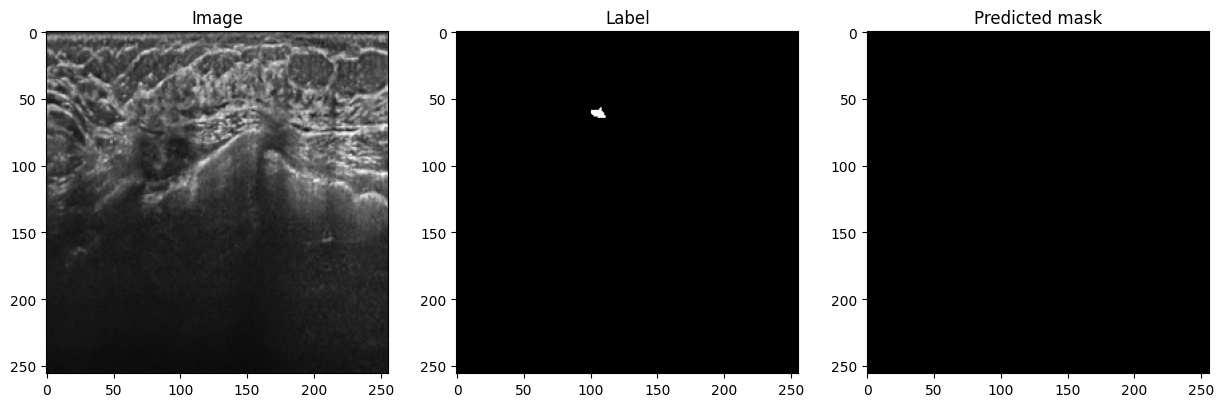

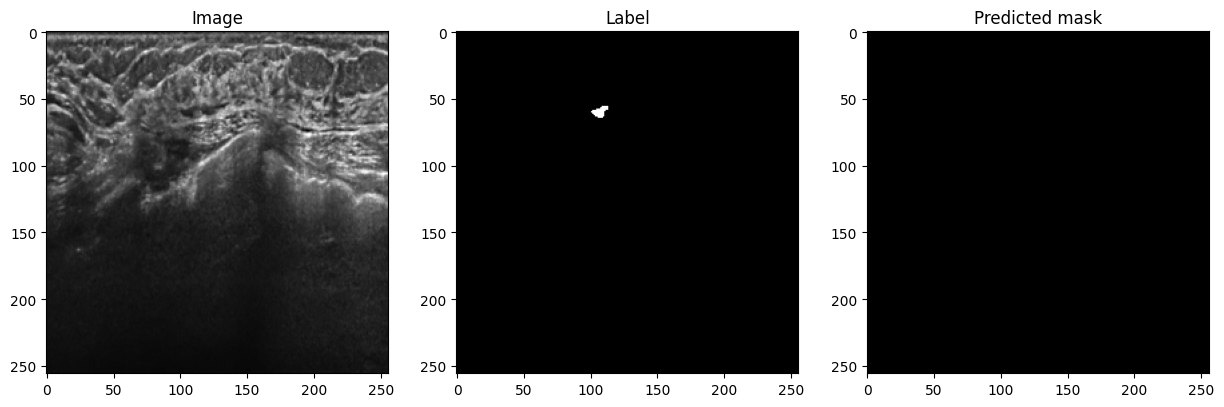

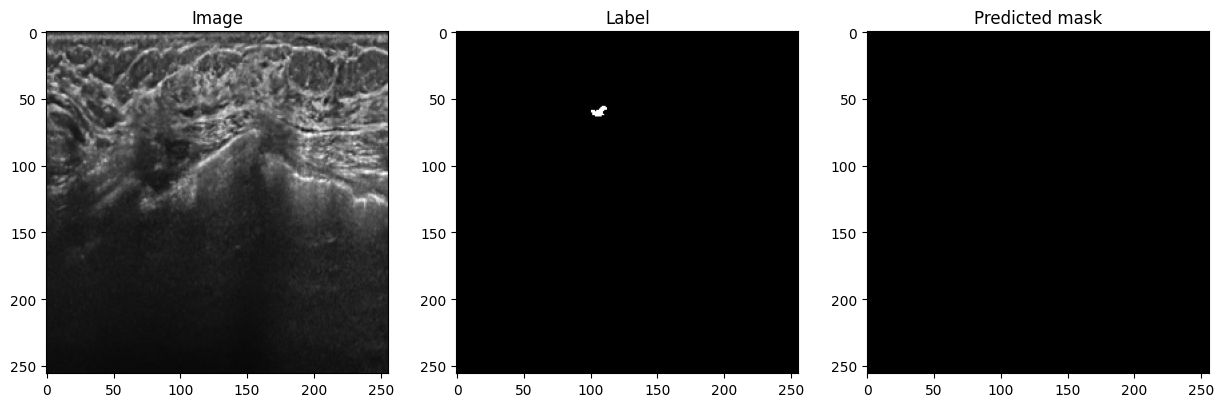

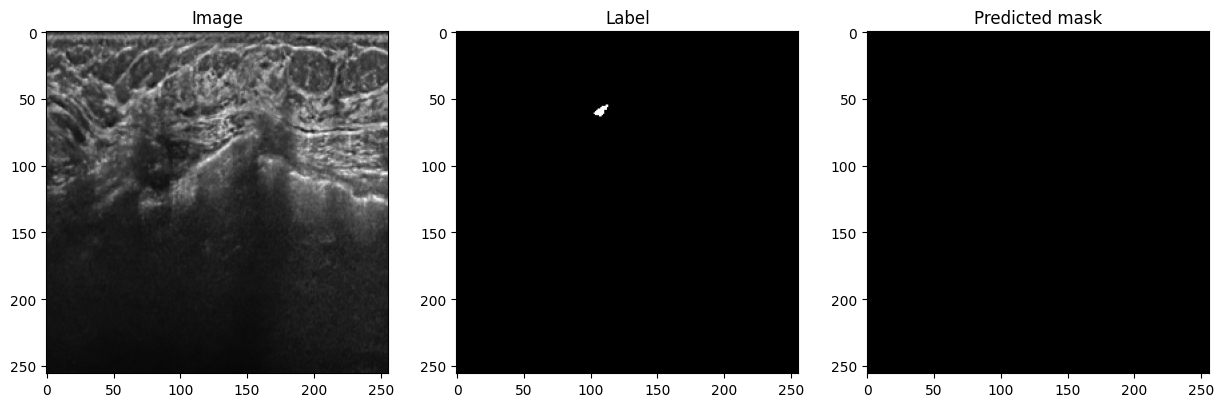

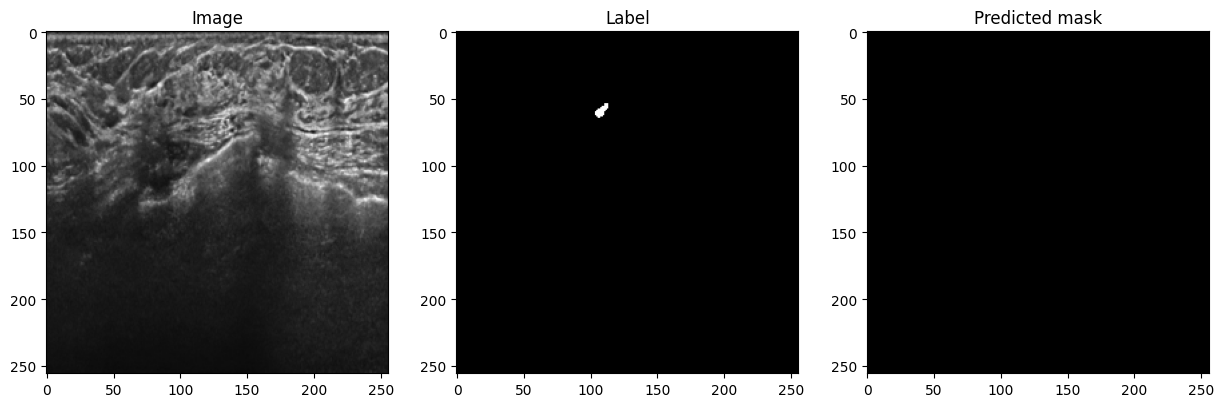

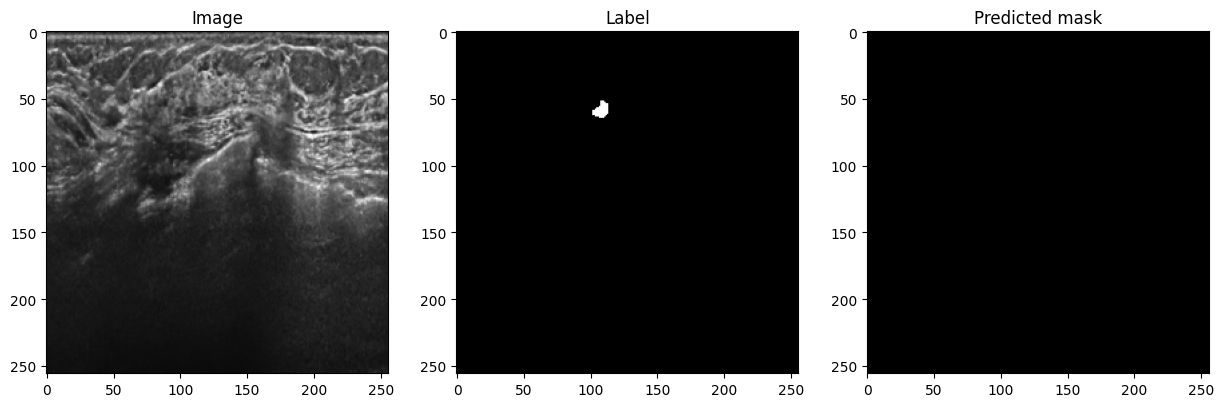

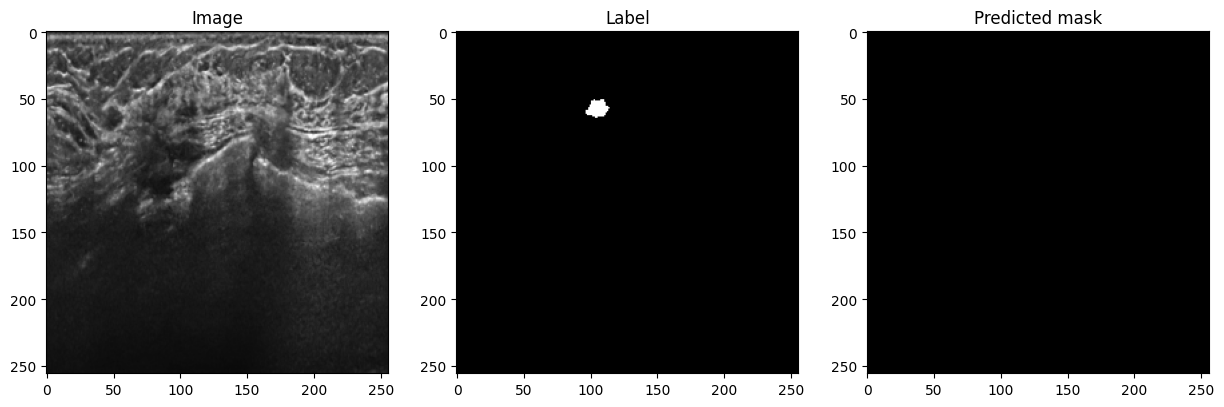

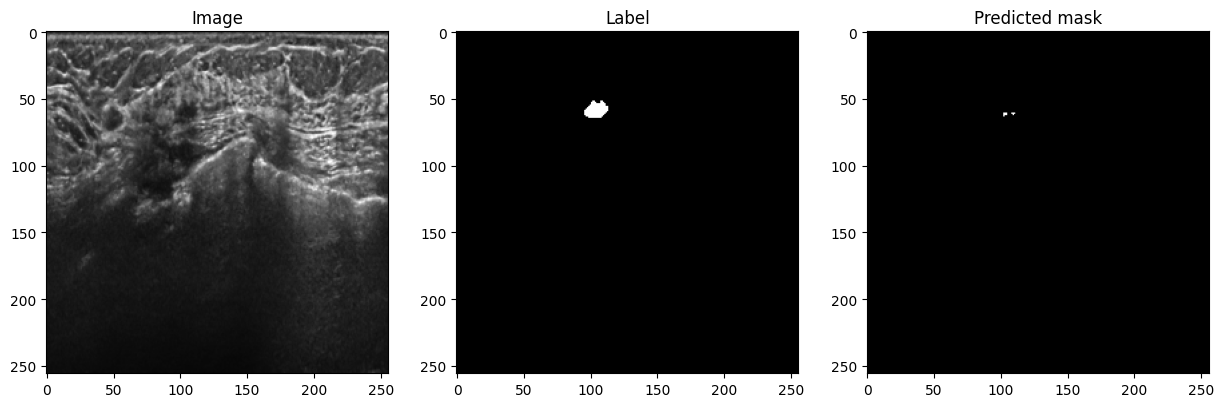

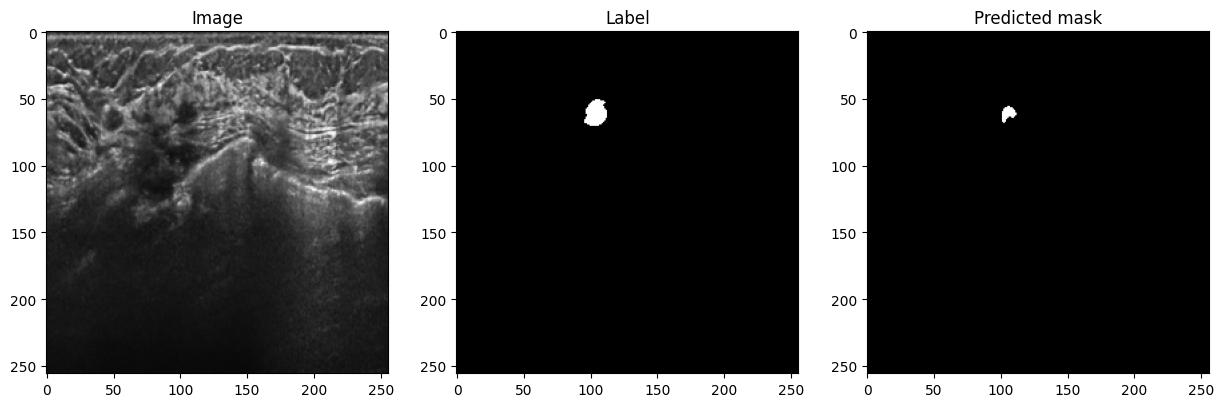

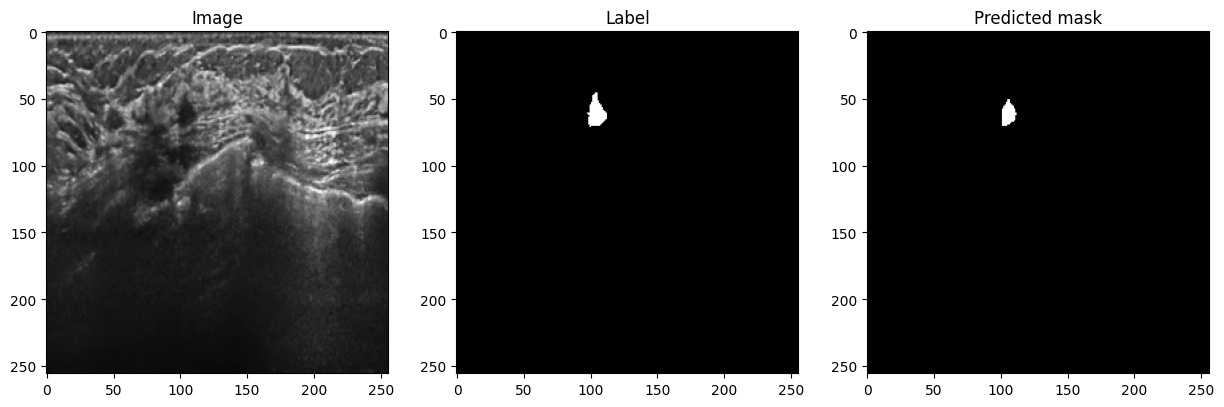

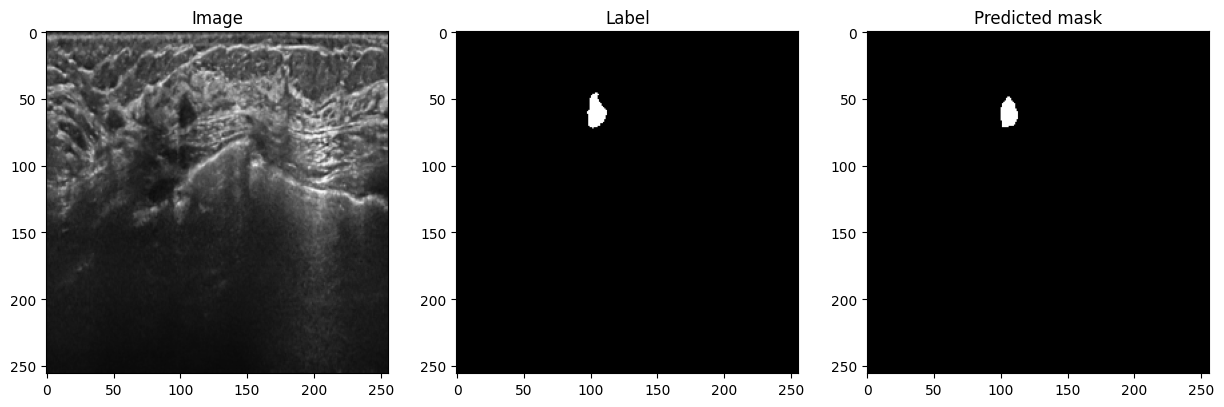

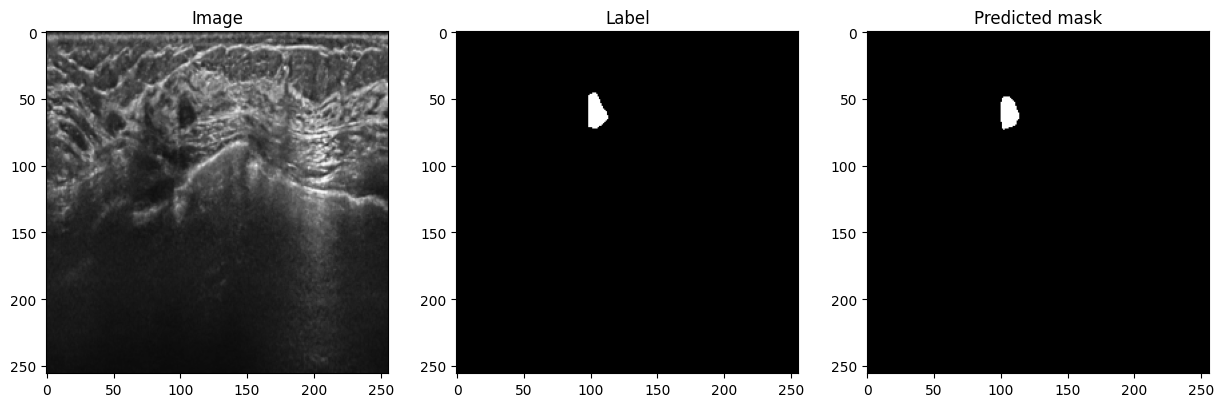

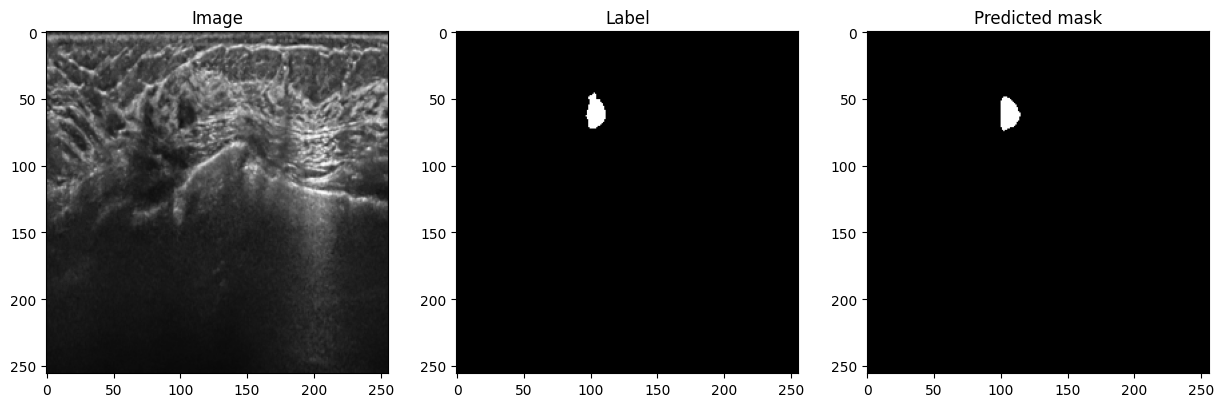

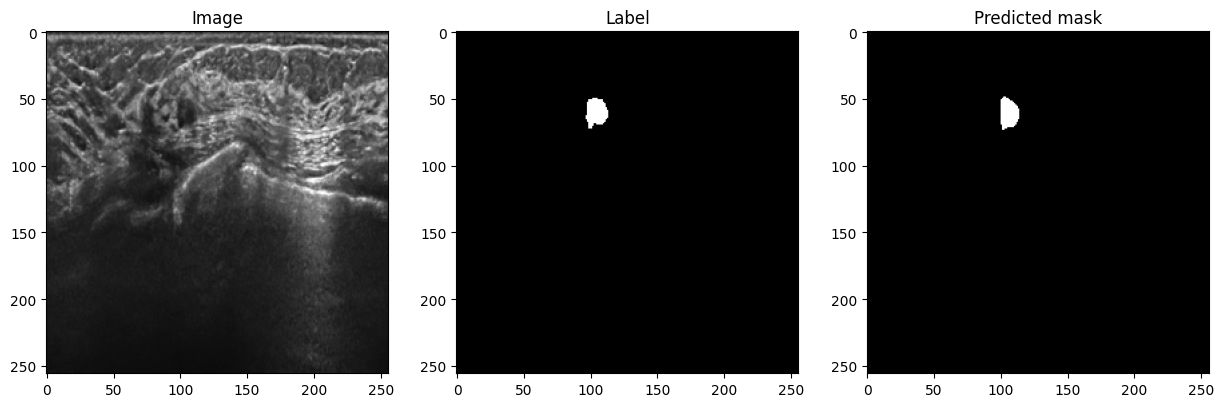

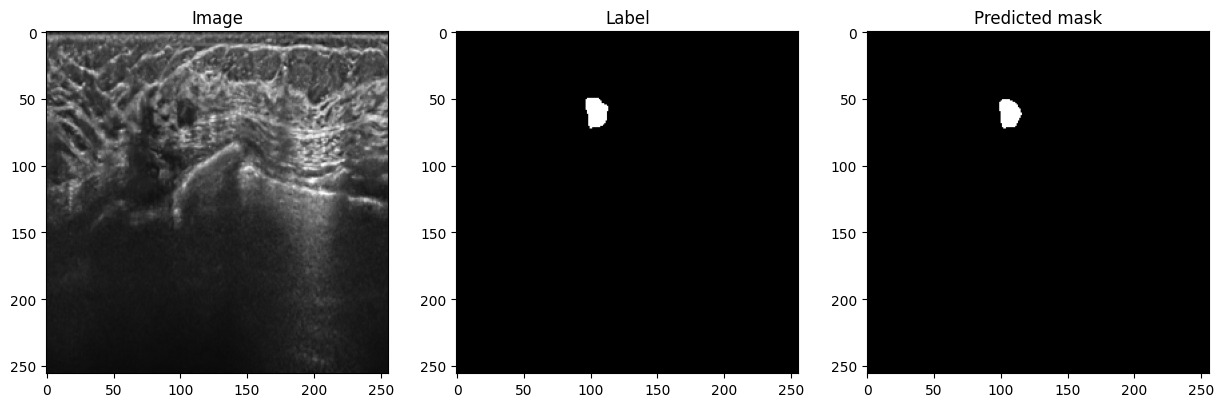

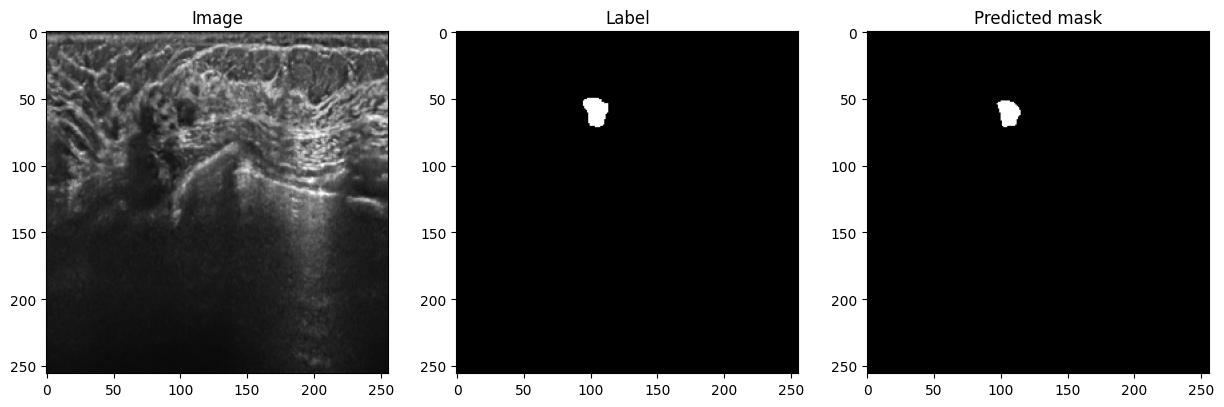

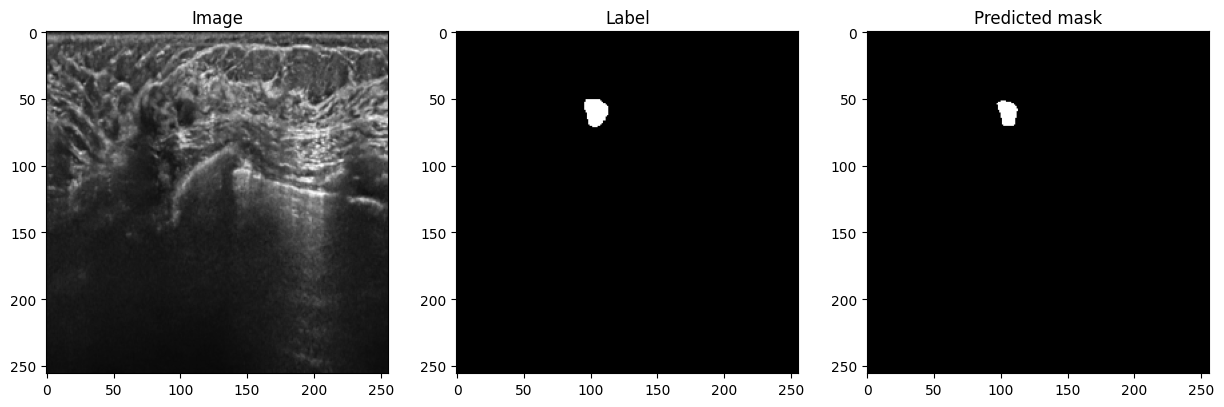

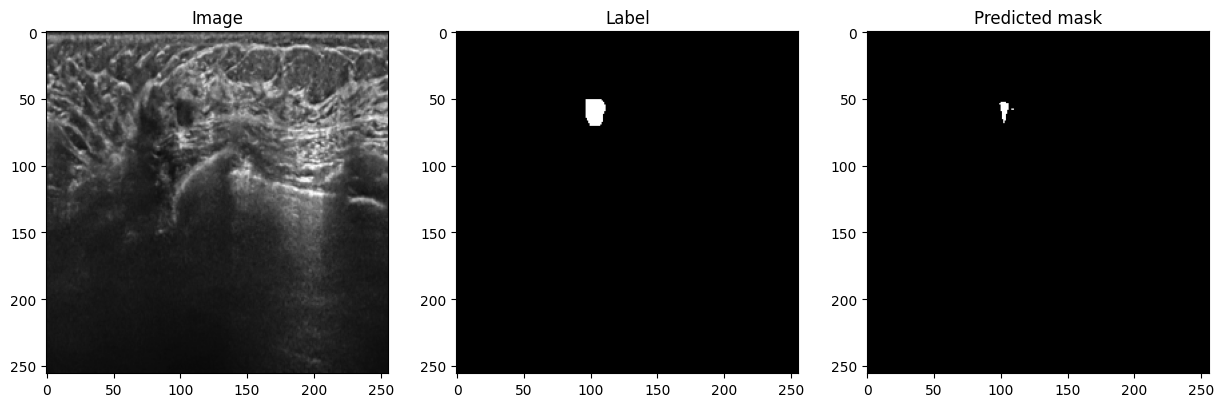

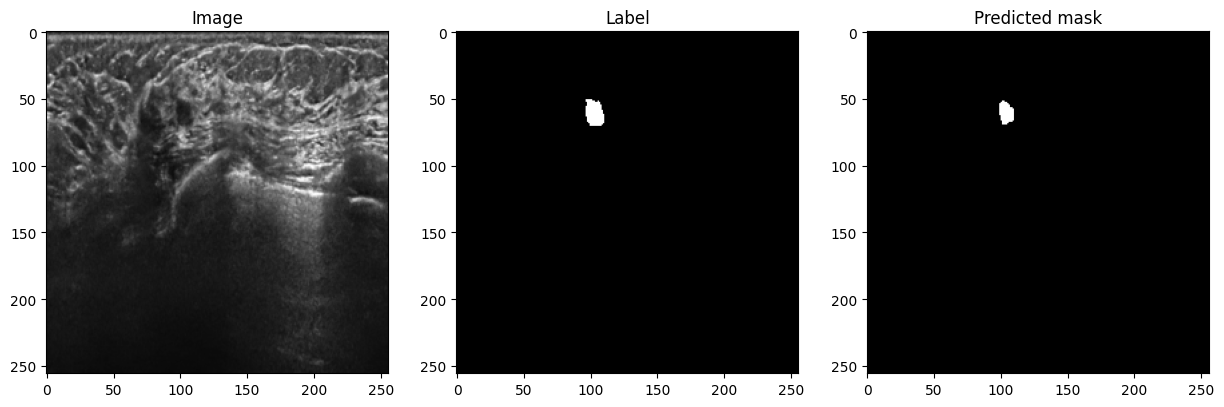

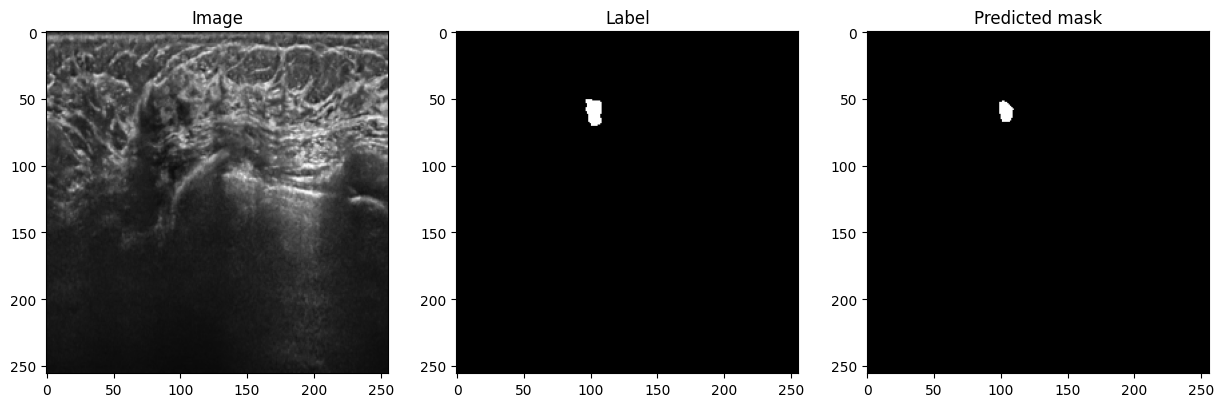

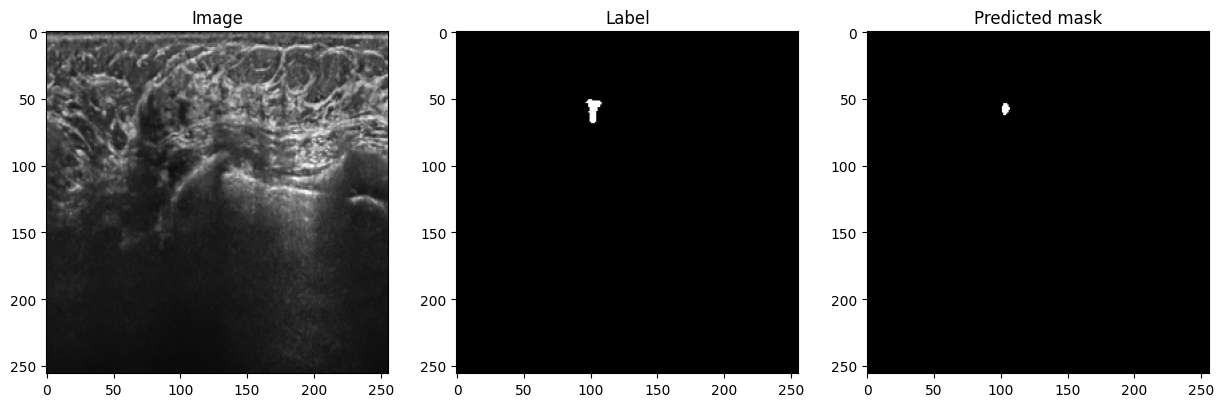

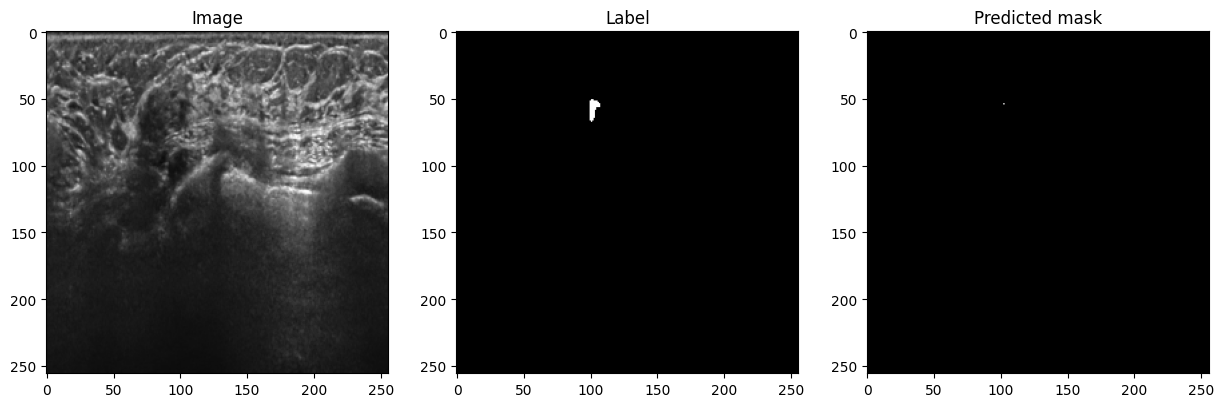

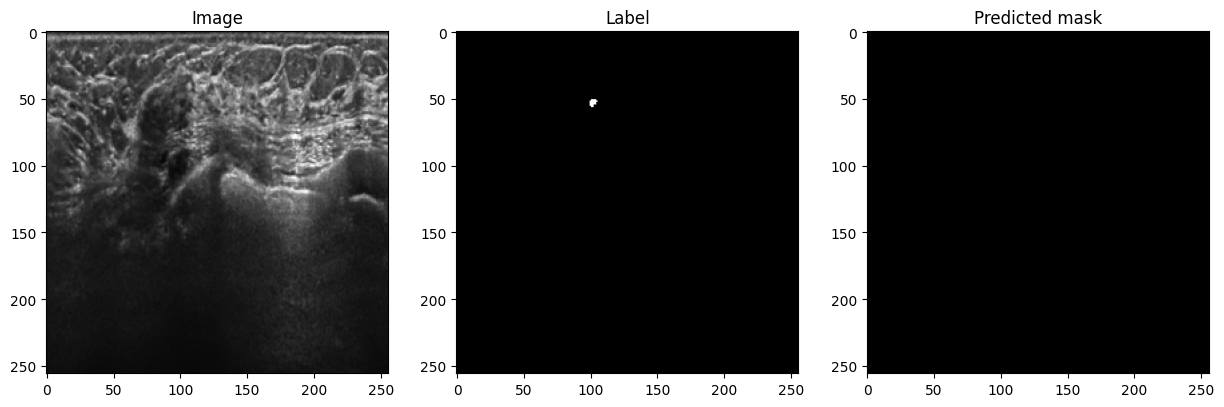

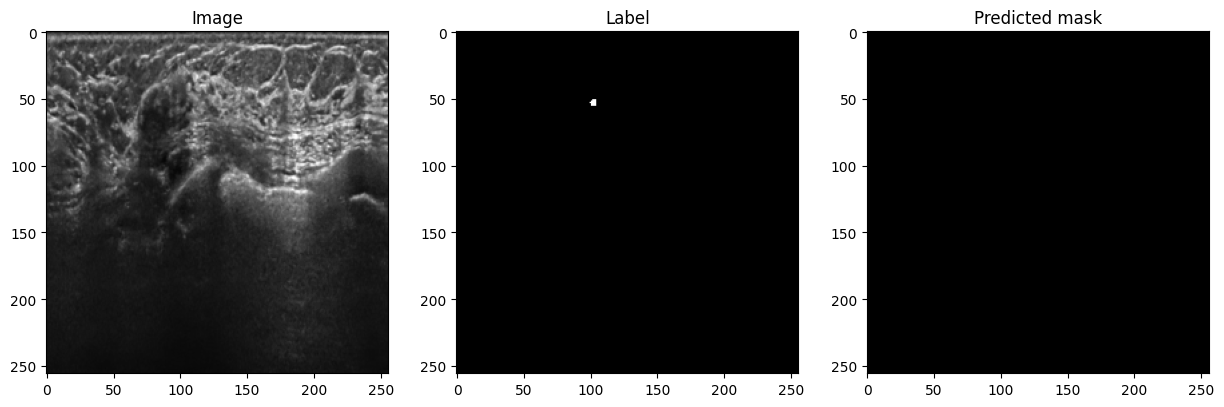

In [7]:
labels_array = np.zeros((len(db_val), 256, 256))
preds_array = np.zeros((len(db_val), 256, 256))
for batch_num, sample_batch in enumerate(valloader):
    # get data
    image_batch, label_batch = sample_batch["image"].to(device), sample_batch["label"].to(device)
    # forward and losses computing
    outputs = model(image_batch, multimask_output, 256)
    output_masks = outputs['masks'].detach().cpu()
    output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=True)

    #label_batch and output_masks in array
    image_batch = image_batch[0, 0, :, :].cpu().numpy()
    label_batch = label_batch[0, :, :].cpu().numpy()
    output_masks = output_masks[0, 0, :, :].numpy()
    # save in array
    labels_array[batch_num, :, :] = label_batch
    preds_array[batch_num, :, :] = output_masks
    # slide jaccard score
    jaccard_value = jaccard_score(label_batch.flatten(), output_masks.flatten())
    
    print(f'Jaccard score for slice {batch_num} is {jaccard_value}')
    # show image, label and predicted mask
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image_batch, cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(label_batch, cmap='gray')
    axs[1].set_title('Label')
    axs[2].imshow(output_masks, cmap='gray')
    axs[2].set_title('Predicted mask')
# get 3D jaccard score
jaccard_value = jaccard_score(labels_array.flatten(), preds_array.flatten())
print(f'Jaccard score for patient {pat_id} is {jaccard_value}')

In [8]:
# analyze output
pure_output = outputs['low_res_logits'].detach().cpu()
pure_mask = outputs['masks'].detach().cpu()

Low resolution logits shape: torch.Size([1, 9, 64, 64])
Masks shape: torch.Size([1, 9, 256, 256])


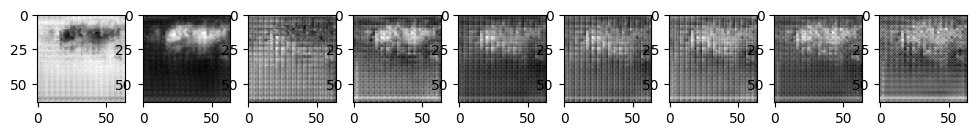

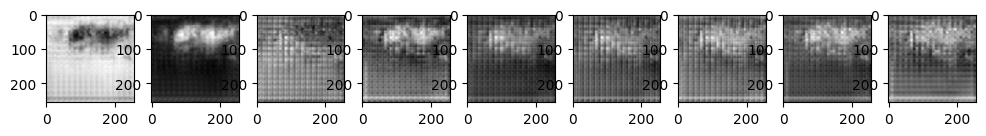

In [9]:
print(f'Low resolution logits shape: {pure_output.shape}')
fig, axs = plt.subplots(1, pure_output.shape[1], figsize=(12, 5))
for i in range(pure_output.shape[1]):
    axs[i].imshow(pure_output[0, i, :, :].numpy(), cmap='gray')
print(f'Masks shape: {pure_mask.shape}')
fig, axs = plt.subplots(1, pure_mask.shape[1], figsize=(12, 5))
for i in range(pure_mask.shape[1]):
    axs[i].imshow(pure_mask[0, i, :, :].numpy(), cmap='gray')

logits after softmax shape: torch.Size([1, 9, 64, 64])


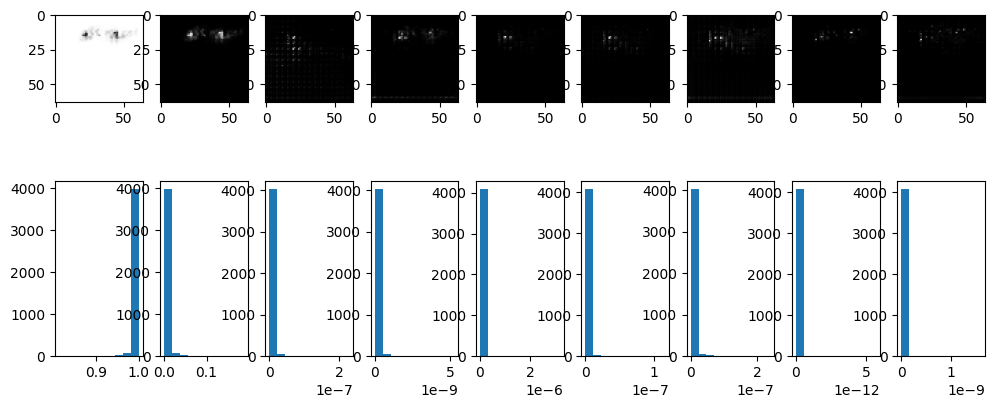

In [10]:
inputs = torch.softmax(pure_output, dim=1)
print(f'logits after softmax shape: {inputs.shape}')
fig, axs = plt.subplots(2, pure_output.shape[1], figsize=(12, 5))
for i in range(pure_output.shape[1]):
    axs[0,i].imshow(inputs[0, i, :, :].numpy(), cmap='gray')
    # histogram per image
    axs[1,i].hist(inputs[0, i, :, :].numpy().flatten())

## Full evaluation

In [7]:
# HP
batch_size = 1
multimask_output = True

patients_jaccard = np.zeros((len(val_ids), 2))
patients_dice = np.zeros((len(val_ids), 2))
for pat_num in range(len(val_ids)):
    pat_id = [val_ids[pat_num]]

    # get data
    root_path = repo_path / 'data/challange_2023/with_lesion'
    path_images = (root_path / "image_mha")
    path_labels = (root_path / "label_mha")
    # get all files in the folder in a list, only mha files
    image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
    # now, we will check if the path has at least one of the ids in the train_ids list
    val_files = [file for file in image_files if any(f'id_{id}_' in file for id in pat_id)]
    # create final paths
    image_files = np.array([path_images / i for i in val_files])
    label_files = np.array([path_labels / i for i in val_files])
    list_val = [image_files, label_files] # this is what we will pass to the dataset <-

    # define dataset and dataloader
    db_val = ABUS_dataset(transform=val_transform,list_dir=list_val)   
    valloader = DataLoader(db_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    print(f'\nThe number of slices is {len(db_val)}')

    labels_array = np.zeros((len(db_val), 256, 256))
    preds_array = np.zeros((len(db_val), 256, 256))
    for batch_num, sample_batch in enumerate(valloader):
        # get data
        image_batch, label_batch = sample_batch["image"].to(device), sample_batch["label"].to(device)
        # forward and losses computing
        outputs = model(image_batch, multimask_output, 256)
        output_masks = outputs['masks'].detach().cpu()
        output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=True)

        #label_batch and output_masks in array
        image_batch = image_batch[0, 0, :, :].cpu().numpy()
        label_batch = label_batch[0, :, :].cpu().numpy()
        output_masks = output_masks[0, 0, :, :].numpy()
        # save in array
        labels_array[batch_num, :, :] = label_batch
        preds_array[batch_num, :, :] = output_masks
        
        # slice jaccard score
        # jaccard_slice = jaccard_score(label_batch.flatten(), output_masks.flatten())
        # print(f'Jaccard score for slice {batch_num} is {jaccard_slice}')
        # # show image, label and predicted mask
        # fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        # axs[0].imshow(image_batch, cmap='gray')
        # axs[0].set_title('Image')
        # axs[1].imshow(label_batch, cmap='gray')
        # axs[1].set_title('Label')
        # axs[2].imshow(output_masks, cmap='gray')
        # axs[2].set_title('Predicted mask')
    # get 3D jaccard score
    jaccard_value = jaccard_score(labels_array.flatten(), preds_array.flatten())
    # dice from jaccard
    dice_value = 2*jaccard_value/(1+jaccard_value)
    print(f'Jaccard score for patient {pat_id} is {jaccard_value}')
    print(f'Dice score for patient {pat_id} is {dice_value}')
    # store in array
    patients_jaccard[pat_num, 0] = pat_id[0]
    patients_jaccard[pat_num, 1] = jaccard_value
    patients_dice[pat_num, 0] = pat_id[0]
    patients_dice[pat_num, 1] = dice_value


The number of slices is 48
Jaccard score for patient [2] is 0.6947481352814958
Dice score for patient [2] is 0.8198836403098905

The number of slices is 14
Jaccard score for patient [7] is 0.5524455483377914
Dice score for patient [7] is 0.7117100486123932

The number of slices is 33
Jaccard score for patient [8] is 0.5020223400465244
Dice score for patient [8] is 0.6684618819064627

The number of slices is 14
Jaccard score for patient [13] is 0.46408104789193616
Dice score for patient [13] is 0.6339554064443979

The number of slices is 39
Jaccard score for patient [16] is 0.24388489208633093
Dice score for patient [16] is 0.3921341816078658

The number of slices is 55
Jaccard score for patient [22] is 0.5943475730882678
Dice score for patient [22] is 0.7455683856149514

The number of slices is 22
Jaccard score for patient [24] is 0.6506140917905624
Dice score for patient [24] is 0.7883297434893285

The number of slices is 35
Jaccard score for patient [26] is 0.5110022763330344
Dice s

In [27]:
db_val.sample_list.shape

(24, 2)

In [31]:
print(f'The jaccard score: \n{patients_jaccard}')
print(f'The dice score: \n{patients_dice}')
print(f'mean dice score: {np.mean(patients_dice[:, 1])}')

The jaccard score: 
[[2.00000000e+00 6.94748135e-01]
 [7.00000000e+00 5.52445548e-01]
 [8.00000000e+00 5.02022340e-01]
 [1.30000000e+01 4.64081048e-01]
 [1.60000000e+01 2.43884892e-01]
 [2.20000000e+01 5.94347573e-01]
 [2.40000000e+01 6.50614092e-01]
 [2.60000000e+01 5.11002276e-01]
 [3.00000000e+01 2.88393238e-02]
 [3.30000000e+01 7.67700450e-01]
 [5.30000000e+01 2.39424938e-01]
 [5.40000000e+01 2.71958666e-01]
 [5.50000000e+01 3.89600404e-01]
 [7.30000000e+01 6.33247384e-02]
 [7.50000000e+01 8.23262188e-01]
 [7.80000000e+01 7.32484076e-02]
 [8.60000000e+01 4.87176846e-01]
 [9.20000000e+01 6.17692605e-01]
 [9.30000000e+01 5.49171660e-01]
 [9.50000000e+01 5.14484357e-01]]
The dice score: 
[[2.00000000e+00 8.19883640e-01]
 [7.00000000e+00 7.11710049e-01]
 [8.00000000e+00 6.68461882e-01]
 [1.30000000e+01 6.33955406e-01]
 [1.60000000e+01 3.92134182e-01]
 [2.20000000e+01 7.45568386e-01]
 [2.40000000e+01 7.88329743e-01]
 [2.60000000e+01 6.76375257e-01]
 [3.00000000e+01 5.60618614e-02]
 [3.3